## An Exploratory Data Analysis of Aircraft Incidents | Tem Orederu & Eduardo Gonzalez  |  8.25.23

## Business Problem

As we expand our business into new industries to diversify our portfolio, we encounter a few challenges that prevent us from moving forward. Specifically, we are considering a potential move into the aviation sector, aiming to establish a dedicated division for planes and helicopters. Unfortunately, we lack key knowledge on the risk factors involved in this industry and need to perform an exploratory analysis to detemine how to best proceed. 

Our company stands firm on a foundational principle: the most effective way to profit is by preserving our capital. Therefore, by minimizing the risks associated with the aircraft industry, we can rest assured that this new wing of our portfolio will meet the expectations of the investment.

Our primary objective is to determine which aircraft makes and models are the safest. We define a "safe" aircraft in two ways. First, one that was not involved in many incidents resulting in severe damage to the plane or helicopter. Second, an aircraft that has positive outcomes for passengers even when it is involved in unfortunate incidents. 

Once we have identified the safest aircrafts, we will explore their best use cases: what they were designed for and what they specialize in. With that information at hand, we can establish a clear business plan within our parameters.

Lastly, we will explore whether there are certain times or certain weather conditions that are safest for flying. Minimizing risk might imply creating a seasonal business. If that’s the case, when should we fly?

Here, we conduct three sets of analyses using [data](https://www.ntsb.gov/Pages/AviationQueryV2.aspx) collected by the [National Transportation Safety Board (NTSB)](https://www.usa.gov/agencies/national-transportation-safety-board). The dataset includes information about aircraft accidents from 1962 to 2023 in the United States and international waters.


## Import packages and data

In [1]:
# Switch to determine whether running the notebook will generate new csvs and pngs (and overwrite previous versions) 
generate_csvs = 0
generate_pngs = 0

In [2]:
# Import necessary packages and suppress warnings
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings('ignore')

## Preview available data

In [3]:
# Load in data from the NTSB and drop duplicate rows 
df = pd.read_csv('data/aviation_data.csv')
df = df.drop_duplicates(keep='first').reset_index(drop=True)

# View shape of data and first 5 rows 
print(df.shape)
df.head()

(88958, 31)


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [4]:
# Drop columns with more than 20% nans 
nan_cols = list(df.loc[:,df.isna().sum()/len(df) > .2].columns) 

# Drop uninformative columns
nan_cols.extend(['Event.Id', 'Investigation.Type', 'Accident.Number', 'Injury.Severity', 'Registration.Number', 'Report.Status', 'Publication.Date'])

# Get a list of columns to keep
non_nan_cols = [x for x in df.columns if x not in nan_cols]

# Re-add the aircraft category column for later cleaning
non_nan_cols.append('Aircraft.Category')
                    
# Remove columns from df
df = df[non_nan_cols].copy()

# Display dropped columns, kept columns, and resulting df
print(f"Dropped columns: {nan_cols}\n")
print(f"Remaining columns: {non_nan_cols}\n")
df.head()

Dropped columns: ['Latitude', 'Longitude', 'Airport.Code', 'Airport.Name', 'Aircraft.Category', 'FAR.Description', 'Schedule', 'Air.carrier', 'Broad.phase.of.flight', 'Event.Id', 'Investigation.Type', 'Accident.Number', 'Injury.Severity', 'Registration.Number', 'Report.Status', 'Publication.Date']

Remaining columns: ['Event.Date', 'Location', 'Country', 'Aircraft.damage', 'Make', 'Model', 'Amateur.Built', 'Number.of.Engines', 'Engine.Type', 'Purpose.of.flight', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured', 'Weather.Condition', 'Aircraft.Category']



,Event.Date,Location,Country,Aircraft.damage,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Aircraft.Category
0,1948-10-24,"MOOSE CREEK, ID",United States,Destroyed,Stinson,108-3,No,1.0,Reciprocating,Personal,2.0,0.0,0.0,0.0,UNK,NaN
1,1962-07-19,"BRIDGEPORT, CA",United States,Destroyed,Piper,PA24-180,No,1.0,Reciprocating,Personal,4.0,0.0,0.0,0.0,UNK,NaN
2,1974-08-30,"Saltville, VA",United States,Destroyed,Cessna,172M,No,1.0,Reciprocating,Personal,3.0,NaN,NaN,NaN,IMC,NaN
3,1977-06-19,"EUREKA, CA",United States,Destroyed,Rockwell,112,No,1.0,Reciprocating,Personal,2.0,0.0,0.0,0.0,IMC,NaN
4,1979-08-02,"Canton, OH",United States,Destroyed,Cessna,501,No,NaN,NaN,Personal,1.0,2.0,NaN,0.0,VMC,NaN


Our company is specifically interested in airplanes and helicopters. Below, we examine the values present in the Aircraft Category column to ensure our dataset is comprised of incidents from airplanes and helicopters. 

In [5]:
# View counts of all aircrafts, including those with an unknown aircraft category type
df['Aircraft.Category'].value_counts(dropna=False)

Aircraft.Category
NaN                  56671
Airplane             27617
Helicopter            3440
Glider                 508
Balloon                231
Gyrocraft              173
Weight-Shift           161
Powered Parachute       91
Ultralight              30
Unknown                 14
WSFT                     9
Powered-Lift             5
Blimp                    4
UNK                      2
Rocket                   1
ULTR                     1
Name: count, dtype: int64

In [6]:
# View ratio of value counts, excluding those with unknown aircraft category type 
df['Aircraft.Category'].value_counts(normalize=True)

Aircraft.Category
Airplane             0.855360
Helicopter           0.106544
Glider               0.015734
Balloon              0.007155
Gyrocraft            0.005358
Weight-Shift         0.004987
Powered Parachute    0.002818
Ultralight           0.000929
Unknown              0.000434
WSFT                 0.000279
Powered-Lift         0.000155
Blimp                0.000124
UNK                  0.000062
Rocket               0.000031
ULTR                 0.000031
Name: proportion, dtype: float64

When we exclude NaN values, we see that 85% of the dataset are airplanes and 10% are helicopters. This is a favorable result, as we are only interested in assessing incidents from airplanes and helicopters. 

The dataset includes several other aircraft types (gliders, balloons, etc), which we will remove from our dataframe to exclude from our analysis. 

There are also over 56k aircrafts with an unmarked aircraft category type. Since 90% of the known dataset comes from airplanes and helicopters, we predict that the vast majority of unknown aircraft types will also be from airplanes and helicopters. 

We will use engine number and engine type to determine which aircrafts are likely airplanes or helicopters and which aircrafts are unlikely to be airplanes or helicopters and should be excluded from our analyses. 

## Filter dataframe for airplanes and helicopters only

In [7]:
# Within the Aircraft Category variable, replace nan with "Unknown" and change "UNK" to "Unknown" 
df['Aircraft.Category'].fillna('Unknown', inplace = True)
df['Aircraft.Category'].replace({'UNK':'Unknown'}, inplace = True)

# Filter the df for airplanes, helicopters, and aircrafts we are unsure of 
df = df[(df['Aircraft.Category'] == 'Airplane') | (df['Aircraft.Category'] == 'Helicopter') | (df['Aircraft.Category'] == 'Unknown')]
df = df.reset_index(drop=True)

# Display value counts of remaining aircrafts
df['Aircraft.Category'].value_counts(dropna=False)

Aircraft.Category
Unknown       56687
Airplane      27617
Helicopter     3440
Name: count, dtype: int64

In [8]:
# Within the Aircraft Category variable, replace nan with "Unknown" and change "UNK" to "Unknown" 
df['Aircraft.Category'].fillna('Unknown', inplace = True)
df['Aircraft.Category'].replace({'UNK':'Unknown'}, inplace = True)

# Filter the df for airplanes, helicopters, and aircrafts we are unsure of 
df = df[(df['Aircraft.Category'] == 'Airplane') | (df['Aircraft.Category'] == 'Helicopter') | (df['Aircraft.Category'] == 'Unknown')]
df = df.reset_index(drop=True)

# Display value counts of remaining aircrafts
df['Aircraft.Category'].value_counts(dropna=False)

Aircraft.Category
Unknown       56687
Airplane      27617
Helicopter     3440
Name: count, dtype: int64

In [9]:
# Check if Number.of.Engines = 0 corresponds to no Engine.Type
df[(df['Number.of.Engines']==0) & ((df['Engine.Type']!='NONE') & (df['Engine.Type'].notna())\
                                   & (df['Engine.Type'] != 'Unknown'))]

,Event.Date,Location,Country,Aircraft.damage,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Aircraft.Category
22549,1989-03-31,"GREAT HARBOR, Bahamas",Bahamas,Destroyed,Cessna,421B,No,0.0,Reciprocating,Unknown,1.0,0.0,0.0,1.0,VMC,Unknown
76006,2015-06-14,"Pell City, AL",United States,Substantial,WEATHERLY,201B,No,0.0,Reciprocating,Aerial Application,0.0,0.0,0.0,1.0,VMC,Airplane


In [10]:
# Replace Number.of.Engines = 0 with Number.of.Engines = Unknown if there is a recorded Engine.Type
replace_indx = list(df[(df['Number.of.Engines']==0) 
                    & ((df['Engine.Type']!='NONE') 
                       & (df['Engine.Type'].notna()) 
                       & (df['Engine.Type'] != 'Unknown'))].index)

df.loc[replace_indx, 'Number.of.Engines'] = 'Unknown'

# Fill nan with Unknown 
df['Number.of.Engines'].fillna('Unknown', inplace = True)

In [11]:
# Drop all aircrafts with no engines 
drop_rows = df.loc[(df['Number.of.Engines']==0)].index
df = df.drop(drop_rows).reset_index(drop=True)

print(f"Dropped {len(drop_rows)} rows.")

Dropped 726 rows.


In [12]:
# Within the Aircraft Category variable, replace nan with "Unknown" and change "UNK" to "Unknown" 
df['Engine.Type'].fillna('UNK', inplace = True)
df['Engine.Type'].replace({'UNK':'Unknown'}, inplace = True)

In [13]:
# Drop aircrafts with engines uncommon for airplanes and helicopters 
drop_engines = ['NONE', 'LR', 'Hybrid Rocket']
df = df[df['Engine.Type'].apply(lambda x: x not in drop_engines)].reset_index(drop=True)

In [14]:
# Amongst remaining rows, drop cells with an unknown number of engines AND unknown engine type.
# We cannot identify whether these are airplanes, helicopters, or other.

drop_rows = df.loc[(df['Number.of.Engines']=='Unknown') & (df['Engine.Type']=='Unknown')].index
df = df.drop(drop_rows).reset_index(drop=True)

print(f"Dropped {len(drop_rows)} unknown rows.")

Dropped 5242 unknown rows.


## Generate key metrics

The dataset includes information on the total number of people with fatal injuries, serious injuries, minor injuries, and uninjured. As a count, this information is difficult to interpret and compare amongst aircrafts, which will inevitably have varying numbers of total passengers. To address this, we calculate the percentage of passengers who died, were injured, and were uninjured for each incident. 

Additionally, we will parse the Event Date column into separate columns for month, day, and year to facilitate future analyses.

In [15]:
# Check if any of the injury columns have true values. If any do, fill nans with 0s. 
# If all columns are nans, assume the data was not logged and keep them as nans. 
injury_cols = ['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']
injury_data_exists = df[injury_cols].apply(lambda col: any(col), axis = 1)

for col in injury_cols:
    df.loc[injury_data_exists & df[col].isna(), col] = 0

In [16]:
# Obtain the total of passengers on the aircraft and the total number of passengers injured 
df['Total.Passengers'] = df['Total.Fatal.Injuries'] + df['Total.Serious.Injuries'] + df['Total.Minor.Injuries']+ df['Total.Uninjured']
df['Total.Injured'] = df['Total.Fatal.Injuries'] + df['Total.Serious.Injuries'] + df['Total.Minor.Injuries']

# Calculate percentages of passengers who died, were injured, and were uninjured.
df['Percent.Injured'] = (df['Total.Injured'] / df['Total.Passengers']) * 100
df['Percent.Uninjured'] = (df['Total.Uninjured'] / df['Total.Passengers']) * 100
df['Percent.Died'] = (df['Total.Fatal.Injuries'] / df['Total.Passengers']) * 100

# Account for division by 0 where the plane had no passengers.
df.loc[df['Total.Passengers'] == 0, ['Percent.Injured','Percent.Died','Percent.Uninjured']] = 0

In [17]:
#Transform the Event Date into three separate fate columns that specify day, month, and year of the incident.
#Drop 'Event.Date' once the columns are created

df['Event.Date'] = pd.to_datetime(df['Event.Date'])
df['Event.Day'] = df['Event.Date'].map(lambda x: x.day)
df['Event.Month'] = df['Event.Date'].map(lambda x: x.month)
df['Event.Month.Name'] = df['Event.Date'].map(lambda x: x.month_name())
df['Event.Year'] = df['Event.Date'].map(lambda x: x.year)
df.drop(['Event.Date'], axis=1, inplace=True)

## Remove amateur built planes

Since our company will build its aircrafts professionally, we are not interested in analyzing data from amateur built planes and will remove them from the dataframe.

In [18]:
# Remove rows where Amateur.Built is Yes or NaN, then remove Amateur.Built column

df = df.drop(df.loc[(df['Amateur.Built']=='Yes') |( df['Amateur.Built'].isna())].index)
df.reset_index(drop = True, inplace = True)
df.drop(columns = 'Amateur.Built', inplace = True)
df = df.reset_index(drop=True)

df.head()

,Location,Country,Aircraft.damage,Make,Model,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,...,Aircraft.Category,Total.Passengers,Total.Injured,Percent.Injured,Percent.Uninjured,Percent.Died,Event.Day,Event.Month,Event.Month.Name,Event.Year
0,"MOOSE CREEK, ID",United States,Destroyed,Stinson,108-3,1.0,Reciprocating,Personal,2.0,0.0,...,Unknown,2.0,2.0,100.000000,0.000000,100.0,24,10,October,1948
1,"BRIDGEPORT, CA",United States,Destroyed,Piper,PA24-180,1.0,Reciprocating,Personal,4.0,0.0,...,Unknown,4.0,4.0,100.000000,0.000000,100.0,19,7,July,1962
2,"Saltville, VA",United States,Destroyed,Cessna,172M,1.0,Reciprocating,Personal,3.0,0.0,...,Unknown,3.0,3.0,100.000000,0.000000,100.0,30,8,August,1974
3,"EUREKA, CA",United States,Destroyed,Rockwell,112,1.0,Reciprocating,Personal,2.0,0.0,...,Unknown,2.0,2.0,100.000000,0.000000,100.0,19,6,June,1977
4,"BOSTON, MA",United States,Substantial,Mcdonnell Douglas,DC9,2.0,Turbo Fan,NaN,0.0,0.0,...,Airplane,45.0,1.0,2.222222,97.777778,0.0,17,9,September,1979


## Clean remaining columns

To complete data cleaning, we will cycle through our remaining columns to check for unknown or miscategorized values. 

In [19]:
# Clean Weather Condition column
# Change the notation "IMC" and "VMC" to have a clear understanding of each condition.
df['Weather.Condition'].replace({'Unk':'Unknown','UNK':'Unknown','VMC':'Visual Meteorological Conditions',\
                                 'IMC':'Instrumental Meteorological Conditions'}, inplace = True)
df['Weather.Condition'].fillna('Unknown', inplace=True)
df['Weather.Condition'].value_counts(dropna=False)

Weather.Condition
Visual Meteorological Conditions          65672
Instrumental Meteorological Conditions     5596
Unknown                                    2446
Name: count, dtype: int64

In [20]:
# Clean Aircraft Damage column
df['Aircraft.damage'].fillna('Unknown', inplace = True)
df['Aircraft.damage'].value_counts(dropna = False)

Aircraft.damage
Substantial    54757
Destroyed      14862
Minor           2131
Unknown         1964
Name: count, dtype: int64

In [21]:
# Clean Location Column
df['Location'] = df['Location'].fillna('Unknown')

In [22]:
#Clean Make Column

#Create a list of 'characters_to_remove' so we can drop puctuation signs that lead to miscategorization 
characters_to_remove = ['(', ')', ',', '.', '%', '?','-']

# Fill 'NaN' values with Unknown.
df['Make'] = df['Make'].str.title().fillna('Unknown')
df['Make'] = df['Make'].map(lambda x: ''.join(char for char in x if char not in characters_to_remove))

In [23]:
# Print the names of the most common 100 makes for visual inspection
print(df['Make'].value_counts()[:50])
print(df['Make'].value_counts()[50:100])

Make
Cessna                         26178
Piper                          14365
Beech                           5129
Bell                            2422
Boeing                          1783
Mooney                          1297
Grumman                         1152
Bellanca                        1030
Robinson                        1027
Hughes                           892
Air Tractor                      658
Aeronca                          632
Maule                            582
Champion                         508
Mcdonnell Douglas                492
Stinson                          438
Luscombe                         410
Aero Commander                   406
De Havilland                     383
Taylorcraft                      379
Schweizer                        375
North American                   375
Aerospatiale                     368
Rockwell                         339
Hiller                           338
Cirrus Design Corp               288
Enstrom                          

We note that some makes are misspelled or are denoted with varying labels. In the following section, we standarize names to ensure incidents are properly atrributed to the correct make. 

We also collapse McDonnell Douglas and Boeing into one category, since Boeing acquired McDonnell Douglas in 1997.

Finally, some makes have a low frequency in the dataset, which might make them more difficult to assess. For this reason, we will keep data only from the 50 most common makes. 

In [24]:
# Clean Make column
# Unify names that have many variations
names_var = {'Boeing': 'Boeing', 'Cirrus':'Cirrus','Airbus':'Airbus','Douglas':'Boeing', \
             'Air Tractor':'Air Tractor','Embraer':'Embraer','Bombardier':'Bombardier'}
for key, value in names_var.items():
    df.loc[df['Make'].str.contains(key), 'Make'] = value
    
df['Make'].loc[df['Make'].str.contains('Robinson Helicopter Company|Robinson Helicopter', case=False)] = 'Robinson'

# Filter df for the 50 most common makes 
top_50_makes = df['Make'].value_counts().index[:50]
df = df[df['Make'].isin(top_50_makes)].reset_index(drop=True)

In [25]:
# Clean Purpose of Flight column
df['Purpose.of.flight'].fillna('Unknown', inplace=True)

In [26]:
# Clean Model column
df['Model'] = df['Model'].str.title().fillna('UNKNOWN')
characters_to_remove = ['(', ')', '/', ' ', '-']
df['Model'] = df['Model'].map(lambda x: ''.join(char for char in x if char not in characters_to_remove))
df['Model'] = df['Model'].map(lambda x: x.lower())

In [27]:
# Print the shape of the final cleaned df
print(df.shape)

# Save the final csv file of cleaned data
if generate_csvs == 1:
    df.to_csv('data/data_clean.csv')

(67290, 23)


In [28]:
# Read in csv of cleaned data and preview data
df = pd.read_csv('data/data_clean.csv')
df.head()

,Unnamed: 0,Location,Country,Aircraft.damage,Make,Model,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,...,Aircraft.Category,Total.Passengers,Total.Injured,Percent.Injured,Percent.Uninjured,Percent.Died,Event.Day,Event.Month,Event.Month.Name,Event.Year
0,0,"MOOSE CREEK, ID",United States,Destroyed,Stinson,1083,1.0,Reciprocating,Personal,2.0,...,Unknown,2.0,2.0,100.000000,0.000000,100.0,24,10,October,1948
1,1,"BRIDGEPORT, CA",United States,Destroyed,Piper,pa24180,1.0,Reciprocating,Personal,4.0,...,Unknown,4.0,4.0,100.000000,0.000000,100.0,19,7,July,1962
2,2,"Saltville, VA",United States,Destroyed,Cessna,172m,1.0,Reciprocating,Personal,3.0,...,Unknown,3.0,3.0,100.000000,0.000000,100.0,30,8,August,1974
3,3,"EUREKA, CA",United States,Destroyed,Rockwell,112,1.0,Reciprocating,Personal,2.0,...,Unknown,2.0,2.0,100.000000,0.000000,100.0,19,6,June,1977
4,4,"BOSTON, MA",United States,Substantial,Boeing,dc9,2.0,Turbo Fan,Unknown,0.0,...,Airplane,45.0,1.0,2.222222,97.777778,0.0,17,9,September,1979


## Visualize key metrics

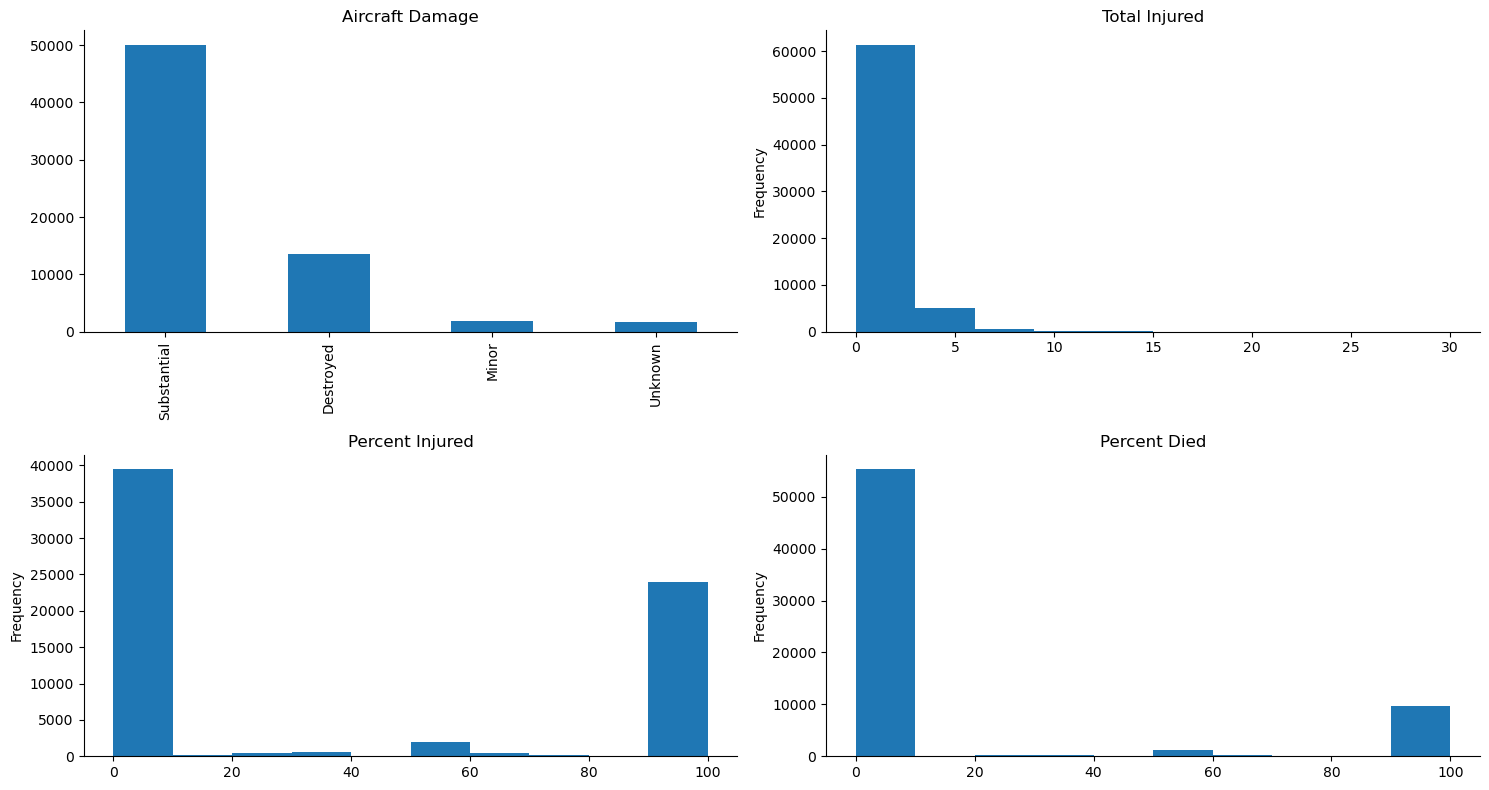

In [29]:
# Visualize distribution of key variables
fig, ax = plt.subplots(2,2, figsize = ((15,8)))

# Aircraft Damage
df['Aircraft.damage'].value_counts().plot.bar(ax=ax[0,0]);
ax[0, 0].set_title("Aircraft Damage")
ax[0, 0].set_xlabel("")

# Total Injured
df['Total.Injured'].plot.hist(ax=ax[0,1], range=[0,30])
ax[0, 1].set_title("Total Injured")
ax[0, 1].set_xlabel("")

# Percent Injured
df['Percent.Injured'].plot.hist(ax=ax[1,0])
ax[1, 0].set_title("Percent Injured")
ax[1, 0].set_xlabel("")

# Percent Died
df['Percent.Died'].plot.hist(ax=ax[1,1]);
ax[1, 1].set_title("Percent Died")
ax[1, 1].set_xlabel("")

plt.tight_layout()
sns.despine()

In [30]:
# Generate and print a list of all the popular makes in the dataset
# Note that the cleaned csv only includes incidents involving the top 50 makes 

popular_makes = list(df['Make'].value_counts().index)
print(f"top makes: {popular_makes}")

top makes: ['Cessna', 'Piper', 'Beech', 'Boeing', 'Bell', 'Robinson', 'Mooney', 'Grumman', 'Bellanca', 'Hughes', 'Air Tractor', 'Aeronca', 'Maule', 'Champion', 'Stinson', 'Cirrus', 'Luscombe', 'Aero Commander', 'De Havilland', 'Taylorcraft', 'Schweizer', 'North American', 'Aerospatiale', 'Airbus', 'Rockwell', 'Hiller', 'Enstrom', 'Ayres', 'Grumman American', 'Embraer', 'Eurocopter', 'Sikorsky', 'Swearingen', 'Ercoupe Eng & Research Corp', 'Fairchild', 'Lake', 'Waco', 'Mitsubishi', 'Aviat', 'Bombardier', 'GrummanSchweizer', 'Socata', 'Ryan', 'Helio', 'Learjet', 'Lockheed', 'Dehavilland', 'Globe', 'Weatherly', 'Wsk Pzl Mielec']


## Damage Index

Each row in the dataset contains information about an aircraft accident. In this section, we calculate a damage index to quantify how destructive the accidents were for a particular make of aircraft. The damage index considers the ratio of planes of a particular make that were destroyed in the incident, compared to the ratio of planes that with substantial damage and minor damage. 

We assume an exponential relationship between levels of aircraft damage, such that incidents with substantial damage are twice as bad as those with minor damage, but incidents with destroyed planes are four times as bad as those with minor damage. 

The damage index formula is as follows: (ratio destroyed x 4) + (ratio subtantial x 2) + (ratio minor x 1).

In [31]:
# Create a new df for calculating the damage index. In this dataframe, "Unknown" 
# values in the Aircraft Damage column will be randomly assigned a value. Random assignments are 
# weighted by the probability distribution of values in the known subset of data. 

# Find the indices of all unknown values in Aircraft Damage 
unk_indices = list(df.loc[df['Aircraft.damage'] == 'Unknown'].index)

# Calculate the probability of observing each value in the current dataset
damage_probs = df['Aircraft.damage'].value_counts()
damage_probs = damage_probs.drop('Unknown')
damage_probs = damage_probs / damage_probs.sum()

# Randomly generate new values for Aircraft Damage based on probabilities observed in known dataset 
rand_damage = np.random.choice(list(damage_probs.index), size = len(unk_indices), p = list(damage_probs))

# Create a new dataset with the new unknown values in Aircraft Damage replaced 
adj_df = df.copy()
adj_df['Aircraft.damage'].iloc[unk_indices] = rand_damage

In [32]:
# Create a df for the damage index 
di_df = pd.DataFrame(columns = ['Damage_Index', 'Num.Incidents.Make', 'Uninjured_P', 'Injured_P', 'Died_P'], )

# Get mean values for each make of aircraft
pop_means_df = adj_df.groupby('Make').mean(numeric_only=True)

# Populate the damage index df using mean values for each make of aircraft
for make in popular_makes:
    make_info = adj_df[adj_df['Make'] == make]['Aircraft.damage'].value_counts(normalize=True)

    # Some makes do not have 
    if 'Minor' not in make_info.index:
        make_info['Minor'] = 0

    damage_index = (make_info['Destroyed'] * 4) + (make_info['Substantial'] * 2) + (make_info['Minor'] * 1)

    # Add additional relevant info to damage index df 
    num_incidents = adj_df['Make'].value_counts()[make]
    make_stats = list(pop_means_df.loc[make].reindex(['Percent.Uninjured', 'Percent.Injured', 'Percent.Died']))
    di_df.loc[make] =[damage_index, num_incidents] + make_stats

In [33]:
# Adjust the damage index by penalizing makes with too few datapoints (n) 
# All with makes with n < threshold are penalized 
threshold = 2000
penalty_rate = 0.25
di_df['Penalty'] = di_df['Num.Incidents.Make'].apply(lambda x: 1 + penalty_rate * np.log(threshold/x) if x < threshold else 1)
di_df['Adj_Damage_Index'] = di_df['Damage_Index'] * di_df['Penalty'] 
di_df.sort_values(by = 'Adj_Damage_Index')

,Damage_Index,Num.Incidents.Make,Uninjured_P,Injured_P,Died_P,Penalty,Adj_Damage_Index
Boeing,2.036842,2660.0,79.388114,14.484066,5.477698,1.000000,2.036842
Cessna,2.358889,26178.0,64.193118,35.692282,14.270196,1.000000,2.358889
Piper,2.438079,14365.0,58.658095,41.265330,18.640403,1.000000,2.438079
Bell,2.478530,2422.0,52.456202,47.378645,14.959588,1.000000,2.478530
Robinson,2.313819,1469.0,57.374631,42.285001,18.015657,1.077141,2.492310
Beech,2.549815,5129.0,54.037588,45.786939,26.107833,1.000000,2.549815
Mooney,2.531997,1297.0,48.496530,51.349268,25.872526,1.108273,2.806145
Air Tractor,2.347333,881.0,58.815740,41.184260,15.020810,1.204961,2.828445
Grumman,2.499132,1152.0,66.146612,33.853388,9.557252,1.137912,2.843792
Bellanca,2.441748,1030.0,55.072816,44.927184,18.988673,1.165897,2.846826


In [34]:
# Identify the top three makes based on the damage index 
top3makes = list(di_df.sort_values(by = 'Adj_Damage_Index').index[:3])
print(top3makes)

# Add new column to df indicating whether the incident involves a make in the top 3
df['DI.Top3'] = df['Make'].apply(lambda x: x in top3makes)

['Boeing', 'Cessna', 'Piper']


To validate that the damage index captures meaningful information, we will plot each make's damage index against key metrics (percent of passengers injured, percent of passengers uninjured, and percent of passengers who died). If the index captures meaningful information, we would expect to see positive, negative, and positive correlations, respectively. 

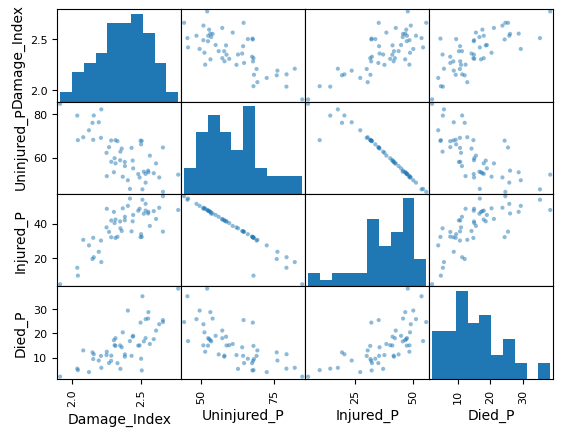

In [35]:
# Validate the damage index by plotting it against key metrics to observe relationships between the variables 
pd.plotting.scatter_matrix(di_df[['Damage_Index', 'Uninjured_P', 'Injured_P', 'Died_P']]);

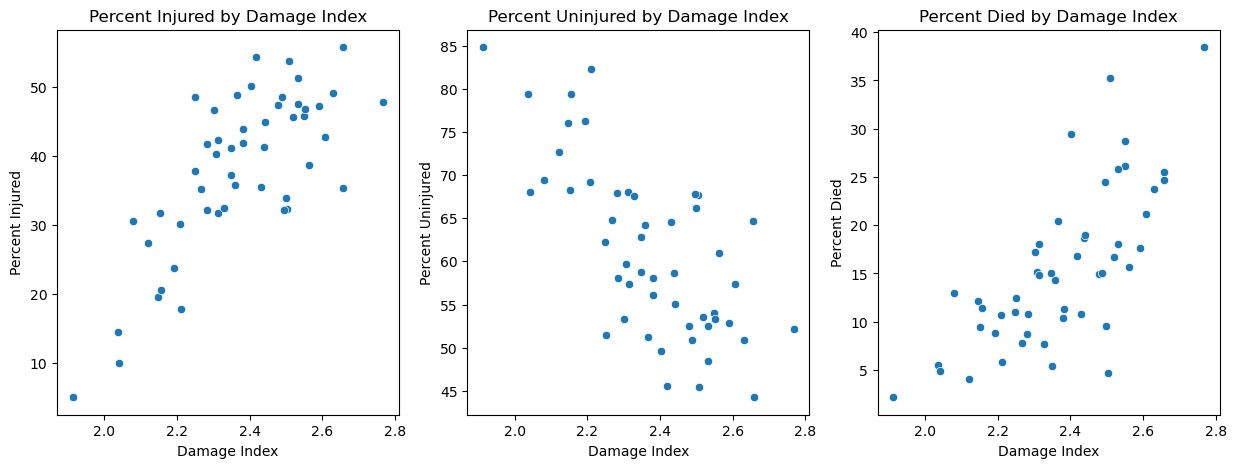

In [36]:
# Re-generate plots and save png
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=di_df['Damage_Index'], y=di_df['Injured_P'], ax=axes[0])
axes[0].set_title("Percent Injured by Damage Index")
axes[0].set_xlabel("Damage Index")
axes[0].set_ylabel("Percent Injured")

sns.scatterplot(x=di_df['Damage_Index'], y=di_df['Uninjured_P'], ax=axes[1])
axes[1].set_title("Percent Uninjured by Damage Index")
axes[1].set_xlabel("Damage Index")
axes[1].set_ylabel("Percent Uninjured")

sns.scatterplot(x=di_df['Damage_Index'], y=di_df['Died_P'], ax=axes[2])
axes[2].set_title("Percent Died by Damage Index")
axes[2].set_xlabel("Damage Index")
axes[2].set_ylabel("Percent Died")

if generate_pngs == 1:   
    fig.savefig("imgs/di_corrs.png", bbox_inches = 'tight')

As expected, the above plots show a positive correlation between damage index and percent of passengers injured, a negative correlation between damage index and percent of passengers uninjured, and a positive correlation between damage index and percent of passengers who died. This indicates that the damage index is a useful measure when determining an aircraft's risks and safety. 

In [37]:
# Add damage index to df
df = df.join(di_df, how='outer', on='Make')

# Generate csv file of all data with damage indices
if generate_csvs == 1:
    df.to_csv('data/data_analyzed.csv', index_label = 'index')

## Prepare data for performance calculation

Each of our top three makes have low damage indices, however, the question still remains: when an aircraft is involved in an incident that results in damage, do the passengers leave the incident uninjured?

Now that we have identified the top three makes, we will further narrow down our list of aircrafts by selecting the models that have the highest performance, as defined by the ratio of incidents where passengers had positive outcomes. 

For planes that had substantial damage or were destroyed, performance was marked as positive if there were no fatalities. For planes that had minor damage, performance was marked as positive if there were no fatalities or injuries.

An overall performance score is generated by calculating the fraction of incidents that met the positive performance criteria over the total number of incidents for each model.

In [38]:
# Create a df that includes incidents from only the top makes 
df_top_makes = df[df['Make'].apply(lambda x: x in top3makes)].reset_index(drop=True)

In [39]:
# Print a list of all models within the top makes for visual inspection
for make in top3makes:
    print(f"{make}:")
    list_models = list(df[df['Make']==make]['Model'].unique())
    print(f"{list_models}\n")

Boeing:
['dc9', 'a75', '737222', 'dc3', 'dc1030', 'dc1010', 'a75n1', 'b7372h4', '727235', 'b727200', '707131b', 'dc982', 'kc135a', '707123b', '727200', 'e75', 'e75n1', 'dc915f', 'b75n1', 'dc861', 'dc3a', 'dc852', 'rb26c', 'dc3c', '75a', 'a75l300', 'b75', 'dc931', '727233', 'n2s1a75a', '727231', 'pt17', '737291', 'a75300n1', 'dc1030f', 'c47', '727', '727225a', '107', 'dc930', '737200', '707300', 'dc10', '727223', '707323c', 'dc951', '737201', '727225', 'a26c', 'dc854f', '747123', 'b737200', '767231', 'dc950', 'dc6a', 'b26c', 'dc910', '747', 'd75n1', '7372h4', '727222', 'dc871', 'dc863f', '727100', '72731h', 'b737222', 'dc1040', '234er', 'dc932', '727222a', 'b747', 'dc4c55b', 'dc7c', 'dc8', '727231a', 'ib75a', '747121', '767', 'bv107ii', 'pt13d', '727223b', 'b727023', '727247', '747200f', '72721', 'dc33c', 'dc980', '72715c', '727232', 'dc915', 'dc1030cf', '727224', 'b72790c', '747230', '72723', 'dc863', '72735', '72731', '720025', 'c118a', '747122', 'dc873', 'dc854', '737130', 'dc851', '

In [40]:
# Remove extraneous strings observed in visual inspection
to_replace = ['stearmane', 'stearman', 'boeing','probertsonstol','skywagon',\
               'kaerobat','psylane','citation','aerobat','hortonstol', 'rileysuper',\
               'aramvi','crileyturbinee','caravan','ector','skyhawk','turbocenturiont','undesignat']

for string in to_replace:
    df_top_makes['Model'] = df_top_makes['Model'].str.replace(string, '')

In [41]:
# If a particular model has 20 or fewer incidents in our dataset, it will be difficult to make meaningful conclusions about it.
# Therefore, we drop rows from rare models here. 

rare_models = df_top_makes['Model'].value_counts()
rare_models = rare_models[rare_models <= 20].index.tolist()

drop_rows = df_top_makes.loc[df_top_makes['Model'].apply(lambda x: x in rare_models)].index
df_top_makes = df_top_makes.drop(drop_rows).reset_index(drop=True)

In [42]:
# Re-examine models from the top three makes 
for make in top3makes:
    print(f"{make}:")
    list_models = list(df_top_makes[df_top_makes['Make']==make]['Model'].unique())
    print(f"{list_models}\n")

Boeing:
['a75', 'dc3', 'dc1030', 'dc1010', 'a75n1', 'dc982', '727200', 'e75', 'b75n1', 'dc3c', 'dc931', 'pt17', '737200', 'dc951', '747', 'dc932', '767', '737300', '737', '369e', '757', 'md88', '757232', 'md82', 'md11', '500', '7377h4', 'a75n1pt17', '777']

Cessna:
['172m', '180', '140', 'r172k', '172', '152', '150l', '414a', '210l', '182', 't337g', '206', 'tr182', 'a185f', '210', 'tu206g', '172n', 'p210n', '182a', 'tu206f', 'u206', '210n', '310l', '414', 't210n', '310', '150m', '182p', '150', '170b', '180k', '177b', '177rg', '182e', '150h', '340a', '182n', '207', '172rg', '177', '182m', '152ii', 'a188b', '172h', '182l', '172p', 'p206', '150g', 'u206g', '150j', '182h', '182b', '310r', '402b', '185', '172k', '421b', '401', '421', '310d', '172a', '404', '172l', '421c', '210a', '310q', '182c', '170', 't210m', '140a', 'a152', '182rg', '310k', 't188c', '210d', '172g', '501', '182j', '120', '210m', '402c', '340', '180j', '172f', '175', '150f', '182k', 'a185e', 't210l', '170a', '205', '182g',

After removing extraneous strings and dropping rare Models, we still observe repeated Models (or variations of Models) in the data. Below, we further clean the Model column.

In [43]:
# Clean Boeing 
def clean_boeing(model_str):

    abr_str = model_str
    
    if model_str in ['dc982', 'md88', 'md82']:
        abr_str = 'md80'

    if model_str in ['dc1030', 'dc1010']:
        abr_str = 'md10'

    if model_str in ['dc982', 'dc931', 'dc951', 'dc932']:
        abr_str = 'md9'
    
    if model_str in ['a75', 'a75n1', 'e75', 'b75n1', 'a75n1pt17', 'pt17']:
        abr_str = 'm75'

    if model_str.startswith('7'):
        abr_str = model_str[:3]

    return abr_str

In [44]:
# Clean Cessna
def clean_cessna(x):
    y = ''
    for i in x:
        if i.isdigit():
            y += i
    x = y
    return x

In [45]:
# Clean Piper
def clean_piper(x):
    if len(x) > 3:
        x = 'pa'+x[2:4]

    if x == 'j3c':
        x = 'j3'

    if x == '180':
        x = 'pa18'
        
    return x

In [46]:
# Combine Boeing, Cessna, and Piper cleaning functions into a single function and apply it to the df 
make_model_df = df_top_makes[['Make','Model']]
make_model_df = make_model_df.drop_duplicates(keep='first')
make_model_df

def clean_top3(model_str): 
    make = make_model_df[make_model_df['Model'] == model_str]['Make'].values[0]

    if make == 'Boeing':
        return clean_boeing(model_str)
    
    if make == 'Cessna':
        return clean_cessna(model_str)

    if make == 'Piper':
        return clean_piper(model_str)

    if make == 'Robinson':
        return clean_robinson(model_str)

df_top_makes['Abr.Model'] = df_top_makes['Model'].apply(clean_top3)

In [47]:
# Re-examine models from the top3 makes 
for make in top3makes:
    print(f"{make}:")
    list_models = list(df_top_makes[df_top_makes['Make']==make]['Abr.Model'].unique())
    print(f"{list_models}\n")

Boeing:
['m75', 'dc3', 'md10', 'md9', '727', 'dc3c', '737', '747', '767', '369e', '757', 'md80', 'md11', '500', '777']

Cessna:
['172', 'pa18', '140', '152', '150', '414', '210', '182', '337', '206', '185', '310', '170', '180', '177', '340', '207', '188', '402', '421', '401', '404', '501', '120', '175', '205', '411', '195', '500', '303', '305', '190', '550', '441', '425', '320', '208', '525', '560']

Piper:
['pa24', 'pa28', 'pa34', 'pa22', 'pa31', 'pa23', 'pa38', 'pa32', 'pa18', 'pa36', 'pa60', 'pa20', 'pa25', 'pa30', 'pac6', 'pa11', 'pa44', 'j5a', 'pa12', 'pa16', 'pa14', 'j3', 'pa46']



## Model performance within top three makes

For planes that had substantial damage or were destroyed, performance was marked as positive if there were no fatalities. For planes that had minor damage, performance was marked as positive if there were no fatalities or injuries.

An overall performance score is generated by calculating the fraction of incidents that met the positive performance criteria over the total number of incidents for each model.

Note that we only consider incidents after 1989 when evaluating performance. 

In [48]:
# Overwrite main dataframe with info from only the top three makes
df = df_top_makes.copy()

In [49]:
# Subset the df to select for incidents that meet the positive performance criteria
best_dest = df.loc[(df['Aircraft.damage'] == 'Destroyed') & (df['Percent.Died'] == 0) 
        & (df['Event.Year'] > 1989) & (df['Total.Passengers'] != 0)]

best_subs = df.loc[(df['Aircraft.damage'] == 'Substantial') & (df['Percent.Died'] == 0) 
         & (df['Event.Year'] > 1989) & (df['Percent.Injured'] == 0) & (df['Total.Passengers'] != 0)]

best_minor = df.loc[(df['Aircraft.damage'] == 'Minor') & (df['Percent.Died'] == 0) 
          & (df['Percent.Injured'] == 0) & (df['Event.Year'] > 1989) & (df['Total.Passengers'] != 0)]

In [50]:
# Calculate an overall performance score for each model by calculating 
# the fraction of incidents that met the positive performance criteria 
# divided by the total number of incidents for each model.

d_d = best_dest['Abr.Model'].value_counts().to_dict()
d_s = best_subs['Abr.Model'].value_counts().to_dict()
d_m = best_minor['Abr.Model'].value_counts().to_dict()
all_keys = set()
all_keys.update(d_d.keys())
all_keys.update(d_s.keys())
all_keys.update(d_m.keys())
r_d  = {}
for key in all_keys:
    r_d[key] = d_d.get(key, 0) + d_s.get(key, 0) + d_m.get(key, 0)
result_d = {}
for key in all_keys:
    denominator = df['Abr.Model'].value_counts().to_dict().get(key, 1)
       
    if denominator != 0:
        result_d[key] = r_d[key] / denominator
    else:
        result_d[key] = 0 

In [51]:
# Convert the performance dictionary into a pandas series 
model_performance = pd.Series(result_d)
model_performance.index.name = 'Abr.Model'
model_performance.name = 'Performance'
model_performance

Abr.Model
pa25    0.296104
pa11    0.417910
182     0.421346
747     0.357143
305     0.509091
          ...   
dc3c    0.440000
pa60    0.192308
205     0.281250
177     0.380223
175     0.402116
Name: Performance, Length: 75, dtype: float64

In [52]:
# Confirm there are no null values within the model performance series 
model_performance.isna().sum()

0

In [53]:
# Assemble model means into a df
model_stats = df.groupby('Abr.Model')[['Percent.Uninjured', 'Percent.Injured', 'Percent.Died']].mean(numeric_only=True)
perf_df = model_stats.join(model_performance, how='left')
perf_df.head()

# Add performance measure to df
df = df.merge(model_performance, how='left', on='Abr.Model')

To validate that the performance metric captures meaningful information, we will plot each model's performance against key metrics (percent of passengers injured, percent of passengers uninjured, and percent of passengers who died). If the performance metric captures meaningful information, we would expect to see positive, negative, and positive correlations, respectively.

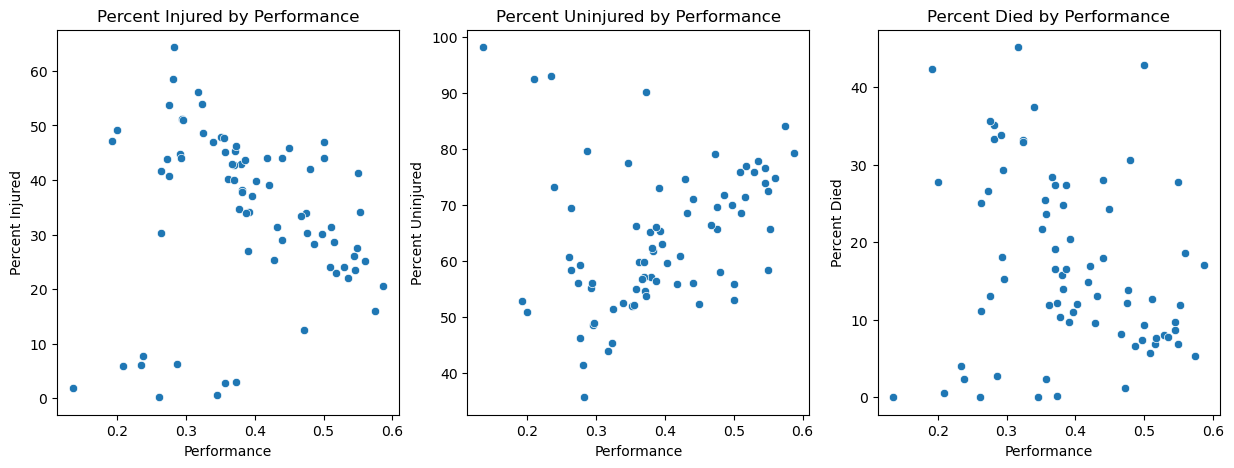

In [54]:
# Validate the performance measure by plotting it against key metrics to observe relationships between the variables 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=perf_df['Performance'], y=perf_df['Percent.Injured'], ax=axes[0])
axes[0].set_title("Percent Injured by Performance")
axes[0].set_xlabel("Performance")
axes[0].set_ylabel("Percent Injured")

sns.scatterplot(x=perf_df['Performance'], y=perf_df['Percent.Uninjured'], ax=axes[1])
axes[1].set_title("Percent Uninjured by Performance")
axes[1].set_xlabel("Performance")
axes[1].set_ylabel("Percent Uninjured")

sns.scatterplot(x=perf_df['Performance'], y=perf_df['Percent.Died'], ax=axes[2])
axes[2].set_title("Percent Died by Performance")
axes[2].set_xlabel("Performance")
axes[2].set_ylabel("Percent Died")

if generate_pngs == 1:   
    fig.savefig("imgs/perf_corrs.png", bbox_inches = 'tight')

As expected, the above plots show a positive correlation between performance and percent of passengers injured, a negative correlation between performance and percent of passengers uninjured, and a positive correlation between performance and percent of passengers who died. This indicates that the performance metric is a useful measure when determining an aircraft's risks and safety. 

Next, we identify the three models with the best performance score for each of the top three makes, resulting in a total of nine top models (three from Boeing, three from Cessna, and three from Piper). 

In [55]:
# Create a df with each model, make, it's performance score, it's corresponding make,
# and whether that make is top3 
make_model = model_stats.reset_index()
make_model = make_model.rename(columns={'index': 'Abr.Model'})
make_model = make_model.merge(df.loc[:,['Make', 'Model', 'Abr.Model']], how='left',on='Abr.Model')
make_model = make_model.merge(model_performance, how='left', on='Abr.Model')
make_model = make_model.drop_duplicates(subset='Abr.Model', keep='first').reset_index(drop=True)
make_model['Top3'] = make_model['Make'].apply(lambda x: x in top3makes)
make_model

,Abr.Model,Percent.Uninjured,Percent.Injured,Percent.Died,Make,Model,Performance,Top3
0,120,71.383648,28.616352,6.918239,Cessna,120,0.515723,True
1,140,71.788991,28.211009,6.651376,Cessna,140,0.486239,True
2,150,59.806552,40.130416,11.849609,Cessna,150l,0.361488,True
3,152,73.101626,26.898374,9.653794,Cessna,152,0.390650,True
4,170,75.896318,24.103682,7.982074,Cessna,170b,0.529070,True
...,...,...,...,...,...,...,...,...
70,pa38,69.549304,30.269208,11.116152,Piper,pa38112,0.263158,True
71,pa44,74.833333,25.166667,18.583333,Piper,pa44180,0.560000,True
72,pa46,58.387375,41.283678,27.708333,Piper,pa46310p,0.549342,True
73,pa60,52.820513,47.179487,42.307692,Piper,pa60,0.192308,True


In [56]:
# Filter for the top three models within the top three makes 
top_make_model = make_model[make_model['Top3']==True]

best_models = []

for make in top3makes:
    
    # Filter for all models within one make 
    subset = top_make_model[top_make_model['Make'] == make]
    
    # Extract best 3 models within one make (based on performance) 
    subset = subset.sort_values(by='Performance', ascending = False)['Abr.Model'][:3]

    best_models.extend(list(subset))

print(best_models)

['369e', 'm75', 'md11', '560', '195', '185', 'pa20', 'pa44', 'j5a']


In [57]:
# Add a new column to the df indicating whether the incident involved a top model
df['Top.Model'] = df['Abr.Model'].apply(lambda x: x in best_models)
df.head()

,Unnamed: 0,Location,Country,Aircraft.damage,Make,Model,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,...,Damage_Index,Num.Incidents.Make,Uninjured_P,Injured_P,Died_P,Penalty,Adj_Damage_Index,Abr.Model,Performance,Top.Model
0,1,"BRIDGEPORT, CA",United States,Destroyed,Piper,pa24180,1.0,Reciprocating,Personal,4.0,...,2.438079,14365.0,58.658095,41.26533,18.640403,1.0,2.438079,pa24,0.357243,False
1,9,"HOBBS, NM",United States,Substantial,Piper,pa28161,1.0,Reciprocating,Personal,0.0,...,2.438079,14365.0,58.658095,41.26533,18.640403,1.0,2.438079,pa28,0.370867,False
2,20,"VAN NUYS, CA",United States,Minor,Piper,pa24180,1.0,Reciprocating,Personal,0.0,...,2.438079,14365.0,58.658095,41.26533,18.640403,1.0,2.438079,pa24,0.357243,False
3,28,"PLEASANT HILL, OR",United States,Destroyed,Piper,pa28161,1.0,Reciprocating,Personal,4.0,...,2.438079,14365.0,58.658095,41.26533,18.640403,1.0,2.438079,pa28,0.370867,False
4,29,"NEAR LAS VEGAS, NV",United States,Destroyed,Piper,pa34200t,2.0,Reciprocating,Unknown,2.0,...,2.438079,14365.0,58.658095,41.26533,18.640403,1.0,2.438079,pa34,0.381466,False


In [58]:
# Save data from top models as a csv
if generate_csvs == 1:
    df.to_csv('data/top_data_analyzed.csv', index_label = 'index')

## Results

Based on the methods explained above, we were able to filter the top performers of all the makes listed using the Damage Index:

Per the Damage Index, the top makes are: Boeing, Cessna and Piper. These are the companies and brands that are the least likely to be involved in an incident in which the aircraft is destroyed or suffers substantial damage. However, this doesn’t mean that they are the safest overall should an incident occur. For this reason, we defer to the second algorithm, the performance model. 

Using the performance model, we can conclude that out of the three top makes we identified, the top performing models are:

Boeing: 369e, m75 and md11.

Cessna: 185, 195 and 560.

Piper: j5a, pa20 and pa44.

With a greater % of our passengers safe and uninjured, we can make sure that even in those accidents in which the aircraft suffers great damage, we can minimize the potential human losses and financial penalties in the form of lawsuits.

## Commonalities

After identifying the top nine aircraft models, we followed-up with research to discover what the models have in common. We assembled this information into a csv file for further analysis and visualization. 

In [59]:
# Import data of the top aircraft information 
ac_info = pd.read_csv('data/top_aircraft_info.csv')

Our online research showed the majority of the models are light, general aviation airplanes. Below are two treeplots (generated with Tableau) that show the distribution of aircraft types and the most popular uses for the top models: 

<div style="text-align: center;">
<img src="imgs/top_model_categories.png" width="700"/>
</div>

<div style="text-align: center;">
<img src="imgs/common_business_uses.png" width="700"/>
</div>

The above plots show that the majority of the final nine models are light, general aviation airplanes. Of their common business uses, touring, recreational flying, private use, and utlity are the most frequently occurring. For this reason, we recommend building a business arm that involves light airplanes used for either private use, recreation flying generally, or touring specifically.

Next, we explored the number of engines each aircraft has and the passenger capacity of each aircraft. We plot this information on a parallel plot below to highlight similarities and differences. 

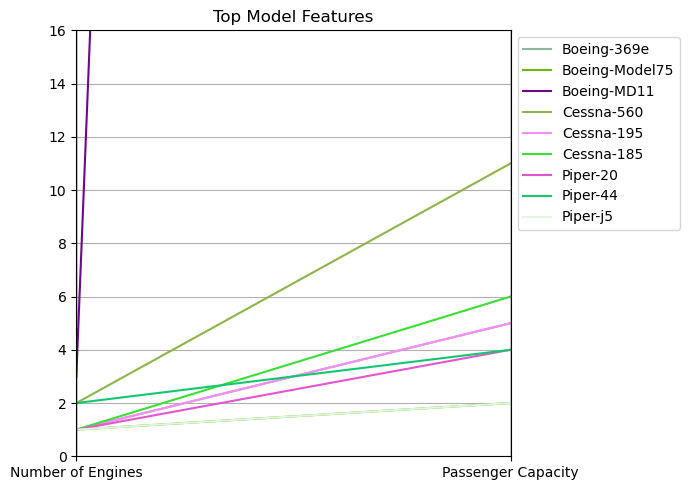

In [60]:
fig, ax = plt.subplots(figsize=(7,5))
pd.plotting.parallel_coordinates(ac_info[['Make.Model', 'Engine.Num', 'Passenger.Capacity']], 'Make.Model', ax=ax)

# 1. Move legend outside of the figure
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 2. Change x-axis labels
xlabels = ["Number of Engines", "Passenger Capacity"]
ax.set_title('Top Model Features')
ax.set_xticklabels(xlabels)
ax.set_ylim(bottom=0, top=16) 

plt.tight_layout()
plt.show()

if generate_pngs == 1:   
    fig.savefig("imgs/model_features.png", bbox_inches = 'tight')

The parallel plot shows that most (4) of the top models have 1 engine, which is consistent with their designation as light aircrafts. As these are predominately smaller aircrafts, the passenger capacity is on the lower range, with most aircrafts having a capacity of 6 or fewer. Note that the Boeing MD11 has three engines, and a passenger capacity of 410, which notably surpasses that of the other aircrafts in our top nine list and is not fully visible on the displayed scale.   

Finally, we explore whether there are certain weather or times that are safest for flying. In the barplot below, we show the performance of our chosen models under varying meteorological conditions: Instrumental Meteorological Conditions (IMC) and Visual Meteorological Conditions (VMC). We color the bars based on the model's injury rate to evaluate whether there is an interaction between meteorological condition and the percentage of people injured. 

<div style="text-align: center;">
<img src="imgs/incidents_injury_rate_weather.png" width="700"/>
</div>

Given the results above, we determine that when the meteorological conditions are categorized as VMC, there tends to be a greater number of incidents compared to when the meteorological conditions are categorized as IMC.

We note that even though there may be more incidents during good visibility (during the daytime or when the weather is clear), these incidents result in a low number of injured passengers. Conversely, there are fewer incidents during poor visibility (during rain, cloudy sky or dark at night), however these incidents result in a high number of injured passengers. 

Therefore, we recommend flying during visual meteorological conditions to avoid passenger injury. We also recommend giving pilots more rigorous training for flying during visual meteorological conditions to avoid the risk of being involved in an incident. 

## Recommendations:
* We recommend that the new business division concentrate on airplanes tailored for general recreation, touring, or private use.
  
* Once a direction among these three is chosen, there are specific plane models to consider. For recreation, models such as the Cessna 195, Cessna 185, Piper PA-20, Piper PA-44, and Boeing 369E are viable options. If touring is the preferred focus, the Cessna 195, Piper PA-20, and Boeing Model 75 stand out. For private use, the Cessna 195, Piper PA-20, and Piper PA-44 are recommended.
  
* Following the selection of a plane, the business should then refine its model. For touring, the business can offer aerial sightseeing tours or charter services tailored for tourists. Under the recreational use category, possibilities include establishing a membership-based flight club, offering lessons for budding pilots, or renting out planes to airshow enthusiasts. For private use, services can range from providing personalized design options for private buyers, to offering exclusive flights, renting out aircrafts, and even offering aircraft maintenance services.

## Next Steps:

* Future analyses can assess data on all US flights spanning from 1962 to 2023 to gauge performance during incident-free flights.
  
* Future analyses can also explore whether the number of engines, phase of the flight and location of the flight influences the flight's safety.
  
* To assess financial viability, it would additionally to conduct a profit/loss analysis of the selected business model. 